In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
STATENUMBER = 1331
ACTIONNUMBER = 27
EPISODELENGTH = 144 # The length of an episode, value is 144 because we divide a day of 24 hours in ten minutes periods.


In [3]:
class Environment:
  def __init__(self, inTransfer, outTransfer):
    self.stepNumber = 0
    self.r0T= 24 # Temperature of room 0.
    self.r1T= 16 # Temperature of room 1.
    self.r2T = 16 # Temperature of room 2.
    self.r0TArray = []
    self.r1TArray = []
    self.r2TArray = []
    self.inTransfer = 0.2 # Heat transfer coefficient between the rooms.
    self.outTransfer = 0.05 # Heat transfer coefficient with the exterior.
    self.TargetTemperature = np.array([20, 20, 20]) # Ideal temperature to reach in each room.

  # Reset the environment to it's initial state.
  def Reset(self):
    self.stepNumber = 0
    self.r0T= 16
    self.r1T = 16
    self.r2T = 16
    self.r0TArray = []
    self.r1TArray = []
    self.r2TArray = []

  # Given an action, use the dynamic of the environment to determine the new state of the agent.
  # Returns the new state and the reward.
  def Step(self, action) :
    self.stepNumber += 1
    extT= self.ExteriorTemperatureCurve()
    self.r0T += action[0] + self.inTransfer * ((self.r1T+self.r2T)/2-self.r0T) +  self.outTransfer * (extT - self.r0T) 
    self.r1T += action[1] + self.inTransfer * ((self.r0T+self.r2T)/2-self.r1T) +  self.outTransfer * (extT - self.r1T) 
    self.r2T += action[2] + self.inTransfer * ((self.r1T+self.r0T)/2-self.r2T) +  self.outTransfer * (extT - self.r2T) 
    reward = self.ComputeReward()
    state = self.AgentState()
    self.r0TArray.append(self.r0T)
    self.r1TArray.append(self.r1T)
    self.r2TArray.append(self.r2T)
    return reward, state

  # The Euclidean distance between the target temperature and the Actual rounded temperature.
  def ComputeReward(self) : 
    return -np.linalg.norm(self.TargetTemperature - self.AgentState())
  
  # A function representing the evolution of temperature during 24 hours, from 6am to 6am.
  def ExteriorTemperatureCurve(self) : 
    return self.Gaussian(self.stepNumber, 72, 20) * 1500 + 5

  # The Gaussian distribution.
  def Gaussian(self, x, mu, sig):
    return (1./(np.sqrt(2*np.pi)*sig))*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

  # Returns the state of the Agent, given the current temperature of the environment.
  def AgentState(self):
    if self.r0T >= 15 and self.r0T <= 25:
        state0 = np.round(self.r0T)
    elif self.r0T < 15 : 
        state0 = 15
    else :
        state0 = 25
    
    if self.r1T >= 15 and self.r1T <= 25:
        state1 = np.round(self.r1T)
    elif self.r1T < 15 : 
        state1 = 15
    else :
        state1 = 25

    if self.r2T >= 15 and self.r2T <= 25:
        state2 = np.round(self.r2T)
    elif self.r2T < 15 : 
        state2 = 15
    else :
        state2 = 25

    return(np.array([state0, state1, state2]))

In [4]:
# QValues are stored in a STATENUMBER x ACTIONNUMBER 2D array.
def InitializeQValues() : 
    return np.zeros(shape=(STATENUMBER,ACTIONNUMBER))


In [5]:
# Retrieve a state (temperature in each room) given an index from the QValue table.
def FromIndexToState(index) :
    num = index
    roomTemp0 = index // 121
    num -= roomTemp0 * 121
    roomTemp1 = num // 11
    num -= roomTemp1 * 11
    roomTemp2 = num
    state = np.array([roomTemp0, roomTemp1, roomTemp2])
    return state + 15

In [6]:
def TestFromIndexToState() : 
    for i in range(STATENUMBER) :
        print(str(i) + " : " + str(FromIndexToState(i)))

In [7]:
# Retrieve the index in the QValue table given a state.
def FromStateToIndex(state) : 
    return int((state[0]-15) * 121 + (state[1]-15) * 11 + (state[2]-15))

In [8]:
def TestFromStateToIndex() : 
    for i in range(11) :
         for j in range(11) :
             for k in range(11) :
                state = np.array([i+15, j+15, k+15])
                print(str(state) + " : " + str(FromStateToIndex(state)))

In [9]:
# Retrieve an action (cooling/heating/idle state of the HVAC appliances) 
# given an index from the QValue table.
def FromIndexToAction(index) :
    num = index
    roomAction0 = index // 9
    num -= roomAction0 * 9
    roomAction1 = num // 3
    num -= roomAction1 * 3
    roomAction2 = num
    action = np.array([roomAction0, roomAction1, roomAction2])
    return action -1

In [10]:
def TestFromIndexToAction() : 
    for i in range(ACTIONNUMBER) :
        print(str(i) + " : " + str(FromIndexToAction(i)))

In [11]:
# Retrieve the index of the action the QValue table,
# given an action (cooling/heating/idle state of the HVAC appliances).
def FromActionToIndex(action) : 
    return int((action[0]+1) * 9 + (action[1]+1) * 3 + (action[2]+1))

def TestFromActionToIndex() : 
    for i in range(3) :
         for j in range(3) :
             for k in range(3) :
                action = np.array([i-1, j-1, k-1])
                print(str(action) + " : " + str(FromActionToIndex(action)))


In [12]:
# Choose the action with the highest QValue available in state "state", 
# or choose an action randomly with probability epsilon.
def ChooseActionEpsilonGreedyPolicy(QValues, state, epsilon) :
    Stateindex = FromStateToIndex(state)
    bestActionIndex = np.argmax(QValues[Stateindex,])
    randomActionIndex = np.random.choice(np.arange(0,ACTIONNUMBER))
    isTakenRandomly = np.random.binomial(1,epsilon)
    if isTakenRandomly == 1 :
        return FromIndexToAction(randomActionIndex)
    else :
        return FromIndexToAction(bestActionIndex)


In [13]:
# Apply the QLearning algorithm with an epsilon greedy policy.
def QLearning(numEpisodes, env, discount, learningRate, epsilon) : 

    QValues = InitializeQValues()
    cumulativeRewards = np.zeros(numEpisodes) # The array of cumulative rewards for the whole training.
    r0TArrays = []
    r1TArrays = []
    r2TArrays = []
    
    # For each episode, representing 24 hours. 
    for i in range(numEpisodes):
        env.Reset()
        cumulativeReward = 0

        for j in range(EPISODELENGTH) :
            state = env.AgentState() 
            stateIndex = FromStateToIndex(state)

            action = ChooseActionEpsilonGreedyPolicy(QValues, state, epsilon)
            actionIndex = FromActionToIndex(action)

            reward, nextState = env.Step(action)
            nextStateIndex = FromStateToIndex(nextState)

            bestNextActionIndex = np.argmax(QValues[nextStateIndex,])

            tdTarget = reward + discount * QValues[nextStateIndex,bestNextActionIndex]
            QValues[stateIndex,actionIndex] += learningRate * (tdTarget - QValues[stateIndex,actionIndex])
            cumulativeReward += reward
        
        r0TArrays.append(env.r0TArray)
        r1TArrays.append(env.r1TArray)
        r2TArrays.append(env.r2TArray)
        cumulativeRewards[i] = cumulativeReward

    return cumulativeRewards, r0TArrays, r1TArrays, r2TArrays

In [14]:
# Compute a moving average with a given windowsize, for a given array of data.
# Useful to smooth the result of the learning.
def MovingAverage(windowSize, data) : 

    i = 0
    movingAverage = []
    while i < len(data) - windowSize + 1:

        windowAverage = np.sum(data[i:i+windowSize]) / windowSize
        movingAverage.append(windowAverage)
        i += 1

    return movingAverage

In [15]:
env = Environment(0.2, 0.05)
cumulativeRewards, r0TArrays, r1TArrays, r2TArrays =  QLearning(numEpisodes=10000, env= env, discount=0.95, learningRate=0.1, epsilon=0.1)

In [16]:
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }

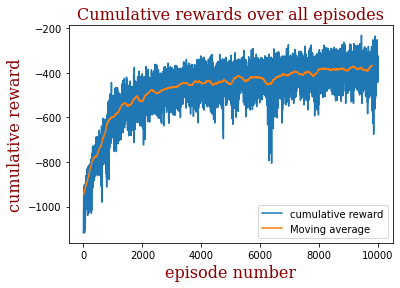

In [17]:
plt.figure(0)
plt.title('Cumulative rewards over all episodes', fontdict=font)
plt.xlabel('episode number', fontdict=font)
plt.ylabel('cumulative reward', fontdict=font)



# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)

plt.plot(cumulativeRewards, label = "cumulative reward")
plt.plot(MovingAverage(200, cumulativeRewards), label = "Moving average")
plt.legend(loc="lower right")

Text(0.5, 1.0, 'Temperature control at episode 0')

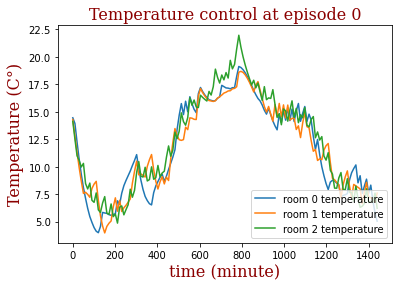

In [18]:
plt.figure(1)
x = np.linspace(0,1440,144)
r0temp = r0TArrays[0]
plt.plot(x,r0temp, label = "room 0 temperature")
r1temp = r1TArrays[0]
plt.plot(x,r1temp, label = "room 1 temperature")
r2temp = r2TArrays[0]
plt.plot(x,r2temp, label = "room 2 temperature")
plt.legend(loc="lower right")
plt.xlabel('time (minute)', fontdict=font)
plt.ylabel('Temperature (C°)', fontdict=font)
plt.title('Temperature control at episode 0', fontdict=font)

Text(0.5, 1.0, 'Temperature control at episode 500')

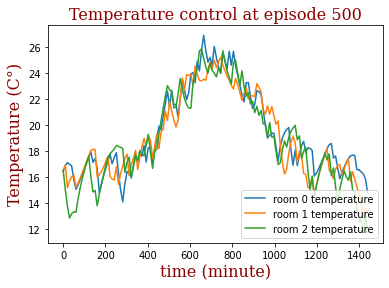

In [20]:
plt.figure(2)
x = np.linspace(0,1440,144)
r0temp = r0TArrays[500]
plt.plot(x,r0temp, label = "room 0 temperature")
r1temp = r1TArrays[500]
plt.plot(x,r1temp, label = "room 1 temperature")
r2temp = r2TArrays[500]
plt.plot(x,r2temp, label = "room 2 temperature")
plt.legend(loc="lower right")
plt.xlabel('time (minute)', fontdict=font)
plt.ylabel('Temperature (C°)', fontdict=font)
plt.title('Temperature control at episode 500', fontdict=font)

Text(0.5, 1.0, 'Temperature control at episode 8000')

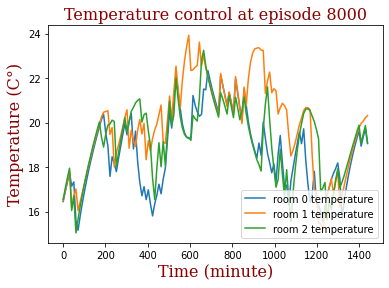

In [21]:
plt.figure(3)
x = np.linspace(0,1440,144)
r0temp = r0TArrays[8000]
plt.plot(x,r0temp, label = "room 0 temperature")
r1temp = r1TArrays[8000]
plt.plot(x,r1temp, label = "room 1 temperature")
r2temp = r2TArrays[8000]
plt.plot(x,r2temp, label = "room 2 temperature")
plt.legend(loc="lower right")
plt.xlabel('Time (minute)', fontdict=font)
plt.ylabel('Temperature (C°)', fontdict=font)
plt.title('Temperature control at episode 8000', fontdict=font)